In [ ]:
# Install necessary packages
!pip install kaggle
import os # System and file handling
import json
import zipfile
import numpy as np # Numerical and data manipulation
import matplotlib.pyplot as plt # Visualization
import seaborn as sns
import tensorflow as tf # Machine Learning / Deep Learning
from tensorflow.keras import models, layers
from sklearn.metrics import classification_report, confusion_matrix



In [ ]:

# Load Kaggle credentials from the saved JSON file
with open('kaggle.json') as file:
    kaggle_credentials = json.load(file)

# Set Kaggle username and key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']


In [ ]:
# Downloading the dataset from kaggle
!kaggle datasets download -d apollo2506/eurosat-dataset


Dataset URL: https://www.kaggle.com/datasets/apollo2506/eurosat-dataset
License(s): CC0-1.0
 98% 1.99G/2.04G [00:12<00:00, 136MB/s]
100% 2.04G/2.04G [00:12<00:00, 175MB/s]


In [ ]:

# Define zip path and extract path
zip_path = "/content/eurosat-dataset.zip"
extract_path = "/content/eurosat"

In [ ]:
# Extract zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" Dataset unzipped successfully.")

 Dataset unzipped successfully.


In [ ]:
# Checking what folders/files are inside the dataset
for root, dirs, files in os.walk("/content/eurosat"):
    print("Folder:", root)
    print("Subfolders:", dirs)
    print("Files:", files[:5])
    break


Folder: /content/eurosat
Subfolders: ['EuroSAT', 'EuroSATallBands']
Files: []


In [ ]:
#Load images using TensorFlow's image_dataset_from_directory


data_dir = "/content/eurosat/EuroSAT"

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(64, 64),
    batch_size=32,
    shuffle=True,
    seed=42
)

class_names = dataset.class_names
print("Classes in the dataset:", class_names)



Found 27000 files belonging to 10 classes.
Classes in the dataset: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


**I found that there are 27000 images which is associated with 10 different classes which are  'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'**

**EDA**

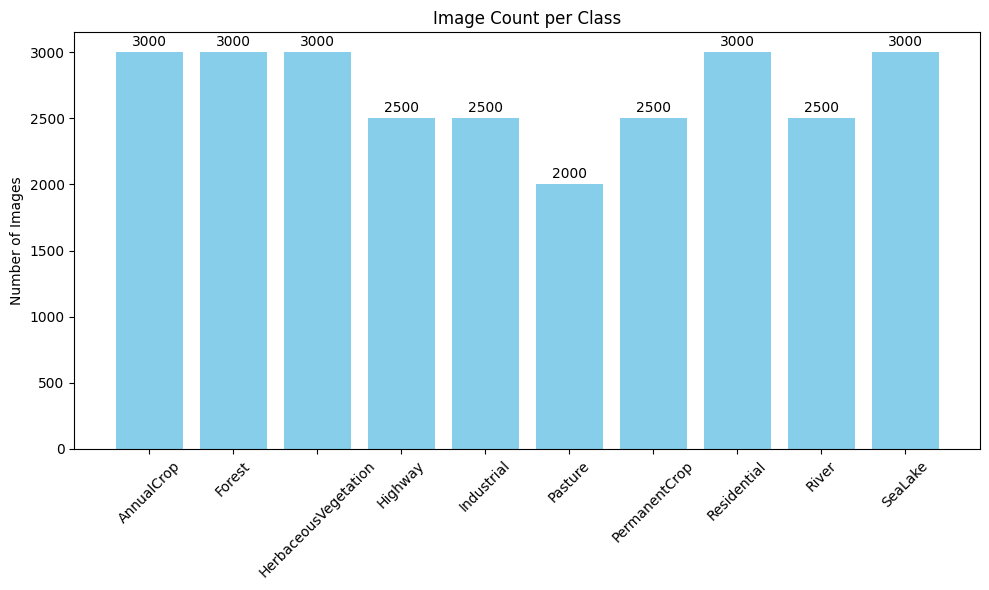

In [ ]:
#Visualizing the number of images in each class


class_counts = {}
for class_name in class_names:
    folder = os.path.join(data_dir, class_name)
    class_counts[class_name] = len(os.listdir(folder))

plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(rotation=45)
plt.title("Image Count per Class")
plt.ylabel("Number of Images")

# Add values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), ha='center')

plt.tight_layout()
plt.show()


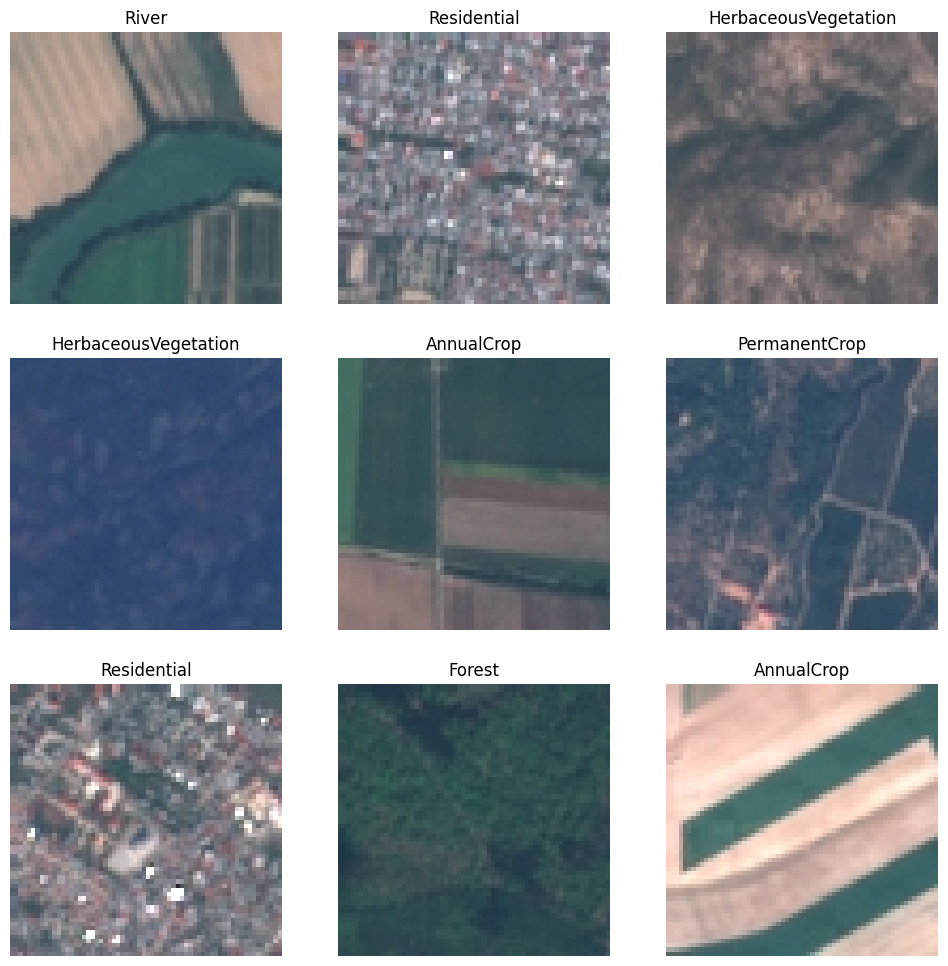

In [ ]:
#  Displaying some random images from the dataset
plt.figure(figsize=(12, 12))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis("off")


In [ ]:
#now we are plitting the dataset into training, validation and test sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(64, 64),
    batch_size=32,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(64, 64),
    batch_size=32,
    label_mode="categorical"
)

# Splitting the val_ds to get a test set
test_batches = val_ds.cardinality() // 2
test_ds = val_ds.take(test_batches)
val_ds = val_ds.skip(test_batches)

print("Train batches:", train_ds.cardinality().numpy())
print("Val batches:", val_ds.cardinality().numpy())
print("Test batches:", test_ds.cardinality().numpy())


Found 27000 files belonging to 10 classes.
Using 21600 files for training.
Found 27000 files belonging to 10 classes.
Using 5400 files for validation.
Train batches: 675
Val batches: 85
Test batches: 84


In [ ]:
#  improving the  performance using prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [ ]:
# Adding data augmentation to improve generalization


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])



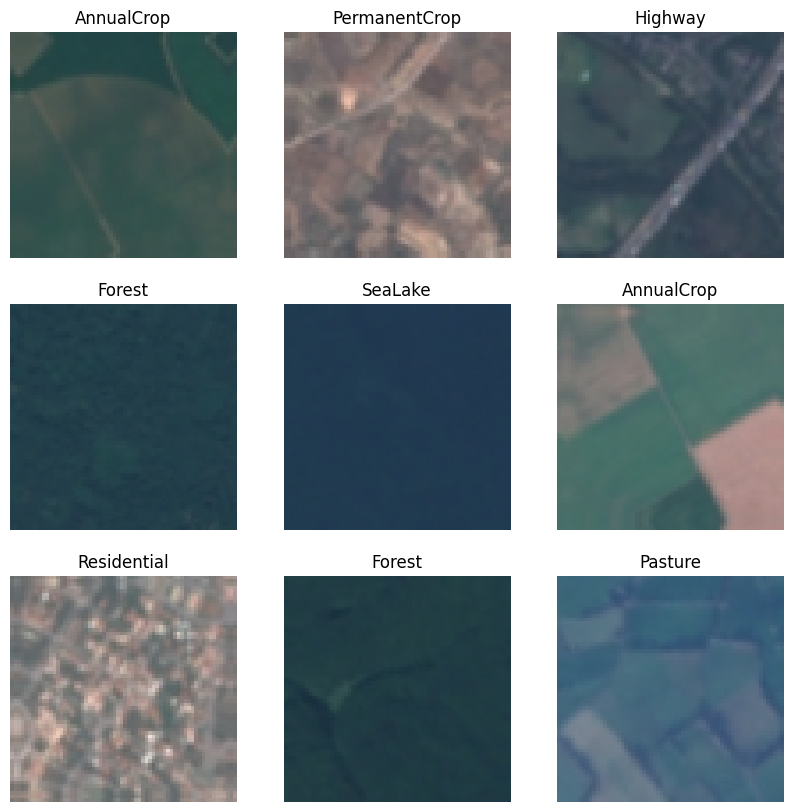

In [ ]:
#  Showing augmented images with class names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_img = data_augmentation(images[i])
        label = class_names[tf.argmax(labels[i])]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_img.numpy().astype("uint8"))
        plt.title(label)
        plt.axis("off")



-----------------------Building a custom CNN model or base model (sequential)









In [ ]:
from tensorflow.keras import models, layers, optimizers, callbacks

# Define your improved CNN model
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(64, 64, 3)),

    # Conv Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Conv Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Conv Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Conv Block 4
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Fully Connected
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # Replace 10 with number of your classes
])

# Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up early stopping
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


675/675 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.5383 - loss: 1.5229 - val_accuracy: 0.6582 - val_loss: 0.9658
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7367 - loss: 0.7675 - val_accuracy: 0.7990 - val_loss: 0.5449
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7822 - loss: 0.6198 - val_accuracy: 0.8049 - val_loss: 0.5472
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8054 - loss: 0.5598 - val_accuracy: 0.8326 - val_loss: 0.4880
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8314 - loss: 0.4960 - val_accuracy: 0.8363 - val_loss: 0.4700
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8433 - loss: 0.4458 - val_accuracy: 0.8403 - val_loss: 0.4394
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8612 - loss: 0.4023 - val_accuracy: 0.8566 - val_loss: 0.4425
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8754 - loss: 0.3527 - val_accuracy: 0.8119 - 

---------------------------------------------- **training the model**-------------------------------

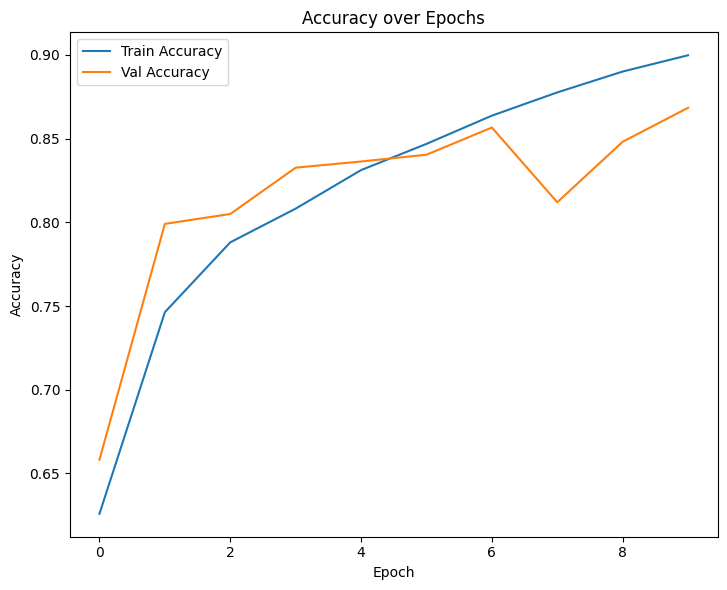

In [ ]:
#Visualize training progress

# Accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


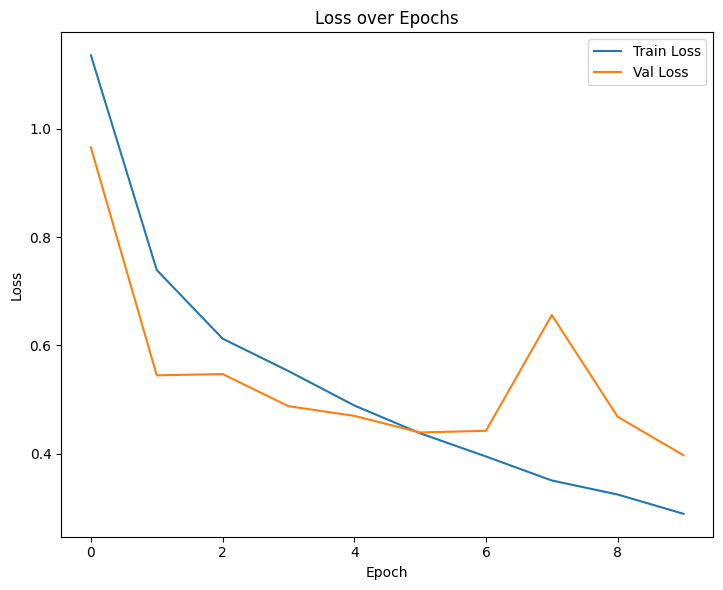

In [ ]:
# Loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

#  Get predictions and true labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Use previously saved class_names
class_labels = class_names  # You got this from dataset.class_names earlier



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

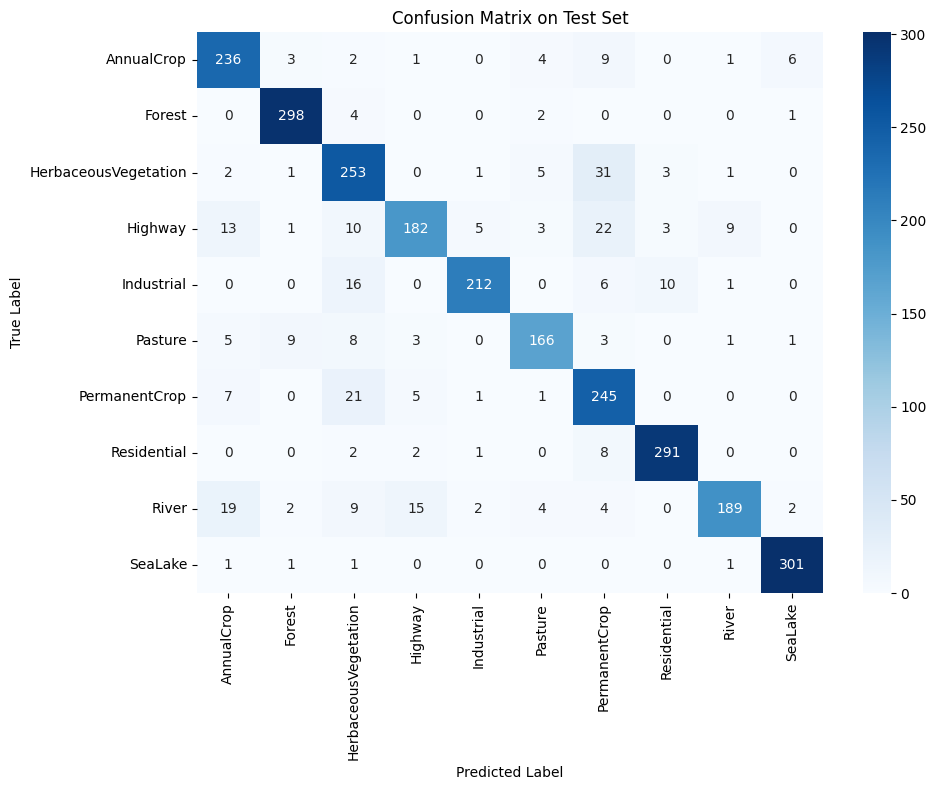

In [ ]:

#  Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()



A few observations:
River and PermanentCrop have more misclassifications.

Some confusion between HerbaceousVegetation ↔ PermanentCrop, which makes sense visually (they can look similar in satellite imagery).

In [ ]:
#  Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.83      0.90      0.87       262
              Forest       0.95      0.98      0.96       305
HerbaceousVegetation       0.78      0.85      0.81       297
             Highway       0.88      0.73      0.80       248
          Industrial       0.95      0.87      0.91       245
             Pasture       0.90      0.85      0.87       196
       PermanentCrop       0.75      0.88      0.81       280
         Residential       0.95      0.96      0.95       304
               River       0.93      0.77      0.84       246
             SeaLake       0.97      0.99      0.98       305

            accuracy                           0.88      2688
           macro avg       0.89      0.88      0.88      2688
        weighted avg       0.89      0.88      0.88      2688



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


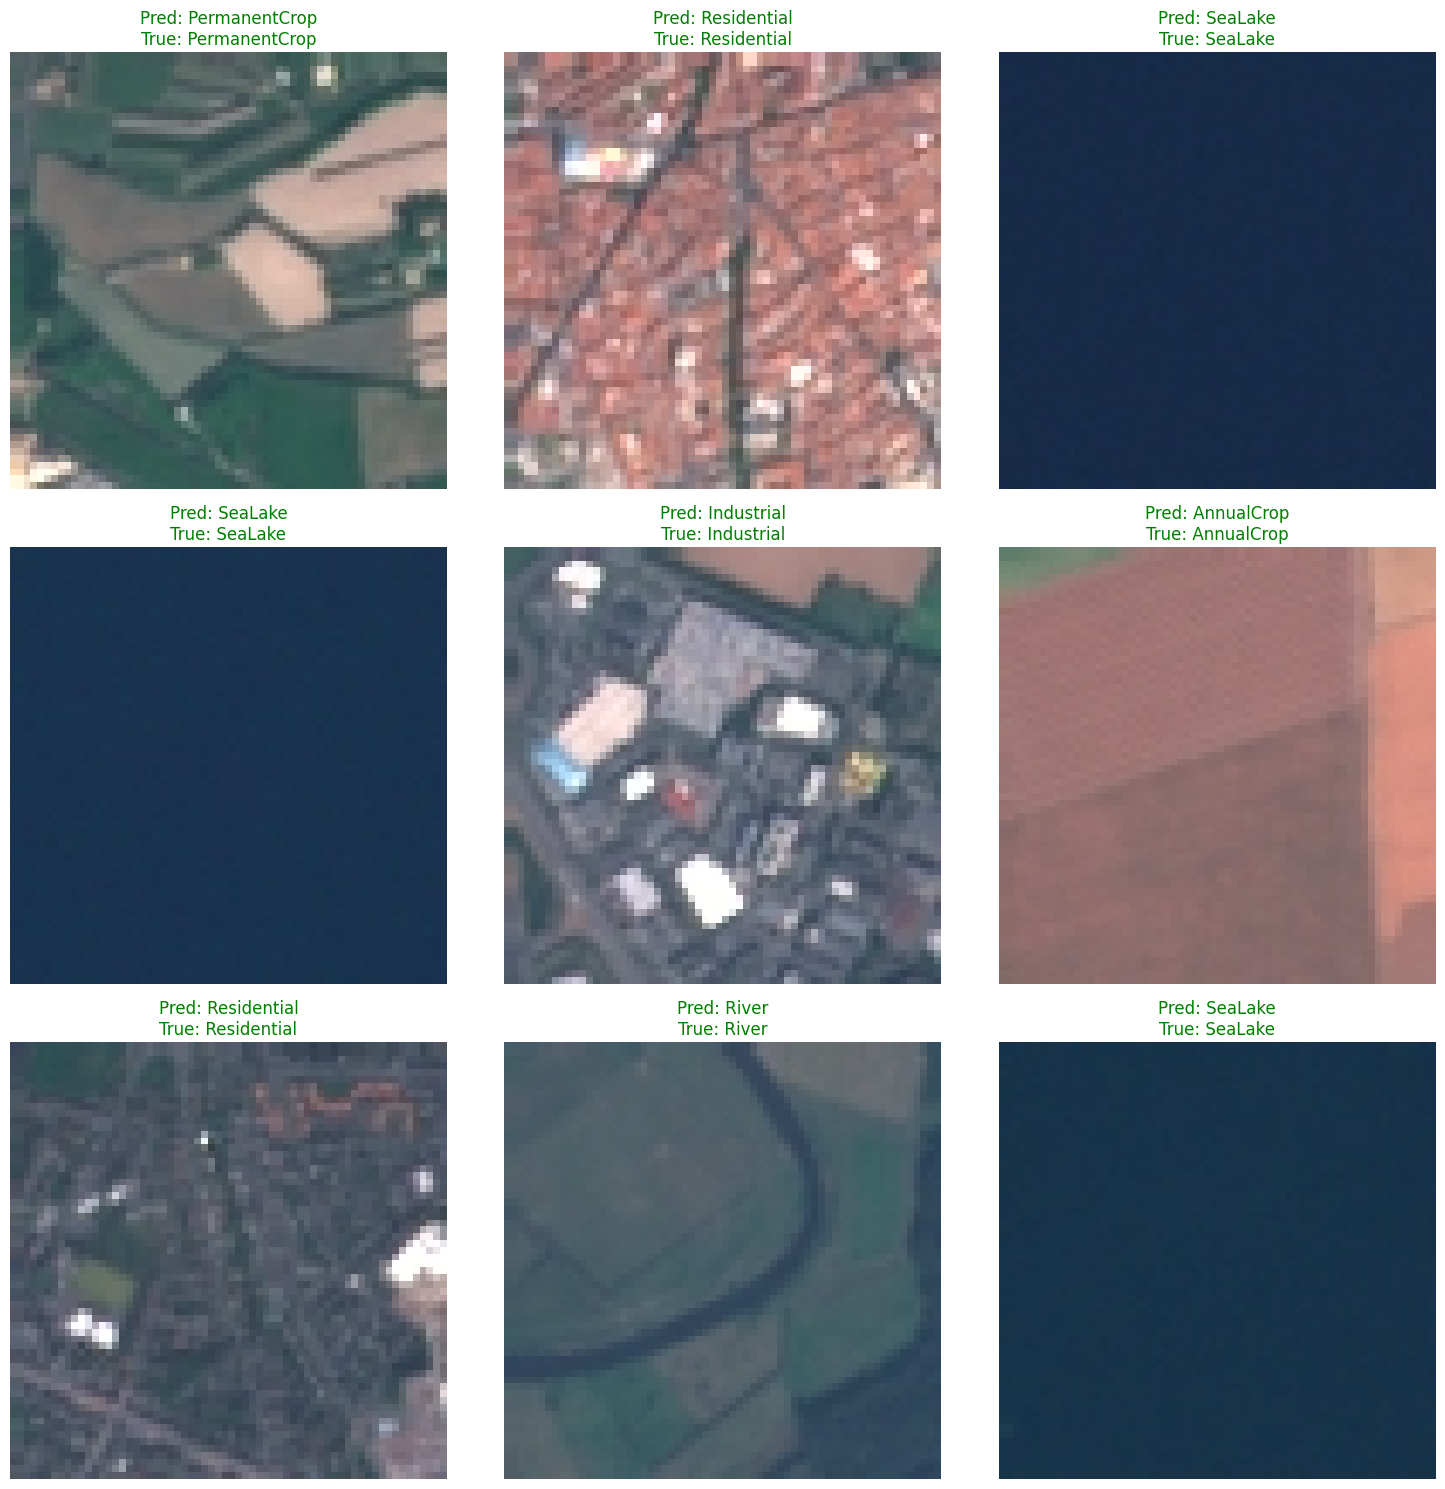

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of test images and labels
for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)
    class_names_list = class_names  # use your defined class_names

    # Plot 9 random images from the batch
    plt.figure(figsize=(15, 15))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_label = class_names_list[predicted_classes[i]]
        true_label = class_names_list[true_classes[i]]
        color = "green" if pred_label == true_label else "red"
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

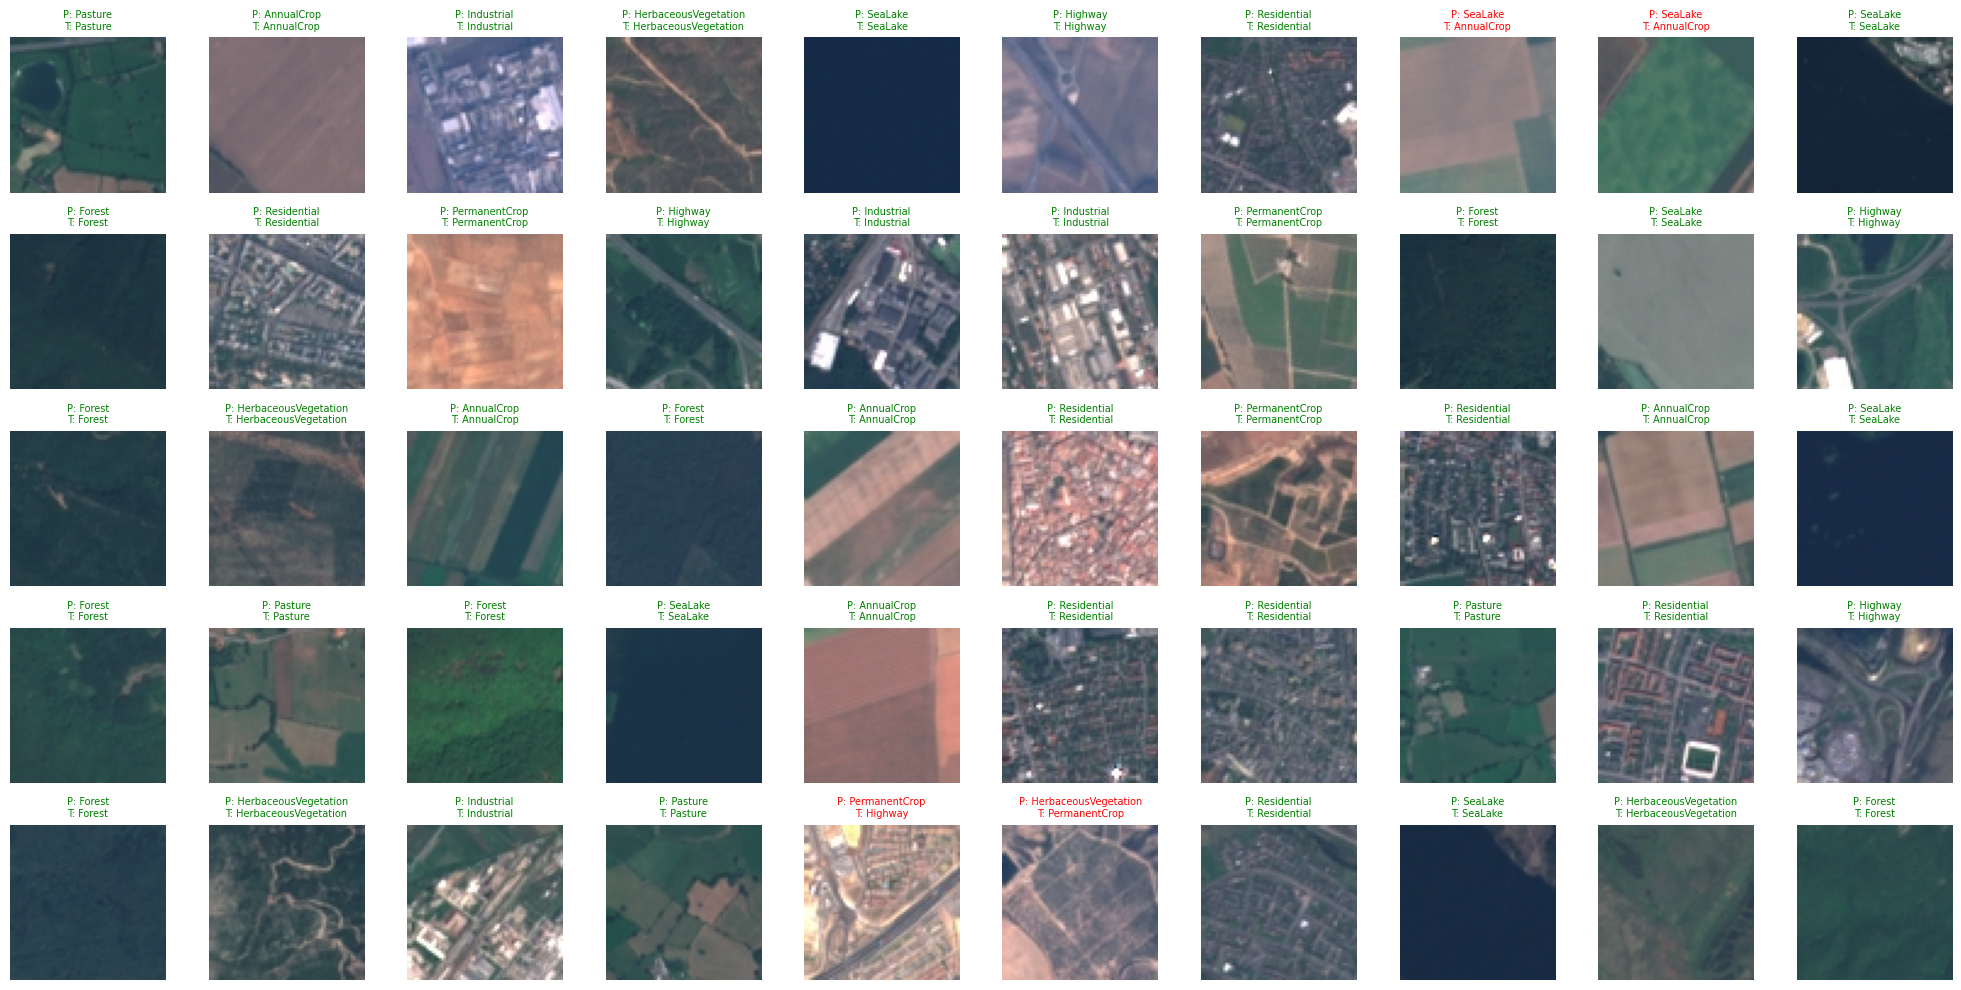

In [ ]:
#adding a code to test on 50 random images as suggested by supervisor
import matplotlib.pyplot as plt
import numpy as np

# Create empty lists to store images, predictions, and true labels
all_images = []
all_preds = []
all_trues = []

# Collect 50 test images and their labels
for images, labels in test_ds.unbatch().take(50):
    img_array = tf.expand_dims(images, axis=0)  # Add batch dimension
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    true_class = np.argmax(labels.numpy())

    all_images.append(images.numpy().astype("uint8"))
    all_preds.append(predicted_class)
    all_trues.append(true_class)

# Plotting the 50 images in a 10x5 grid
plt.figure(figsize=(20, 10))
for i in range(50):
    ax = plt.subplot(5, 10, i + 1)
    plt.imshow(all_images[i])
    pred_label = class_names[all_preds[i]]
    true_label = class_names[all_trues[i]]
    color = "green" if pred_label == true_label else "red"
    plt.title(f"P: {pred_label}\nT: {true_label}", fontsize=7, color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()
